## Анализ сервиса аренды самокатов

Необходимо проанализировать данные и проверить некоторые гипотезы, которые могут помочь бизнесу вырасти. Для этого выполним следующие шаги:

1. Загрузим данные и подготовим их к анализу
2. Выполним исследовательский анализ данных
3. Проверим гипотезы
4. Сделаем выводы

Чтобы совершать поездки по городу, пользователи сервиса пользуются мобильным приложением. 

Сервисом можно пользоваться:

без подписки:

    абонентская плата отсутствует;
    стоимость одной минуты поездки — 8 рублей;
    стоимость старта (начала поездки) — 50 рублей;
    
с подпиской Ultra:

    абонентская плата — 199 рублей в месяц;
    стоимость одной минуты поездки — 6 рублей;
    стоимость старта — бесплатно.

В основных данных есть информация о пользователях, их поездках и подписках.

### Загрузим данные и подготовим их к анализу

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from scipy import stats as st

In [2]:
users  = pd.read_csv("https://code.s3.yandex.net/datasets/users_go.csv", sep=',')
riders = pd.read_csv("https://code.s3.yandex.net/datasets/rides_go.csv", sep=',')
subscriptions = pd.read_csv("https://code.s3.yandex.net/datasets/subscriptions_go.csv", sep=',')

Посмотрим на данные и подготовим их к анализу

In [3]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [4]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


Отлично! Пропусков нет, столбцы имеют нужный тип данных. Идём дальше

In [5]:
riders.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [6]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


Тожё всё хорошо, только стобец date нужно привести к нужному типу

In [7]:
riders['date'] = pd.to_datetime(riders['date'])
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(2), int64(1)
memory usage: 564.8 KB


In [8]:
subscriptions.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


In [9]:
subscriptions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 192.0+ bytes


Всё хорошо, можем продолжить предобработку!

Создим новый столбец с номером месяца на основе столбца date.

Проверим за какой период данные в датасете; если данные за несколько лет, то номера месяцев будут в разных годах одинаковыми

In [10]:
riders.describe()

,user_id,distance,duration
count,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659976,17.805011
std,434.734317,1116.831209,6.091051
min,1.000000,0.855683,0.500000
25%,487.000000,2543.226360,13.597563
50%,889.000000,3133.609994,17.678395
75%,1213.250000,3776.222735,21.724800
max,1534.000000,7211.007745,40.823963


Мы распологаем данными только за 2021 год, поэтому путаницы не будет

In [11]:
riders['month'] = riders['date'].dt.month
riders.head(10)

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8
5,1,2770.890808,16.650138,2021-10-09,10
6,1,3039.020292,14.927879,2021-10-19,10
7,1,2842.118050,23.117468,2021-11-06,11
8,1,3412.690668,15.238072,2021-11-14,11
9,1,748.690645,15.041884,2021-11-22,11


Проверим наличие дубликатов в датафреймах

In [12]:
users.duplicated().sum()

31

In [13]:
users[users.duplicated(keep=False)].sort_values('user_id')

,user_id,name,age,city,subscription_type
15,16,Амалия,27,Краснодар,ultra
1535,16,Амалия,27,Краснодар,ultra
42,43,Стефания,22,Омск,ultra
1539,43,Стефания,22,Омск,ultra
1563,47,Юрий,28,Тюмень,ultra
...,...,...,...,...,...
1554,1198,Демид,29,Ростов-на-Дону,free
1558,1237,Евгения,23,Тюмень,free
1236,1237,Евгения,23,Тюмень,free
1544,1245,Регина,27,Пятигорск,free


Избавимся от дубликатов

In [14]:
users = users.drop_duplicates()
users.duplicated().sum()

0

In [15]:
riders.duplicated().sum()

0

In [16]:
subscriptions.duplicated().sum()

0

Выводы по разделу первичного анализа и предобработки данных:

- в данных не было пропусков
- в данных о пользователях было несколько дубликатов, можно проверить систему сбора данных.

In [18]:
riders['distance'] = riders['distance'].round(2)
riders['distance'].head(3)

0    4409.92
1    2617.59
2     754.16
Name: distance, dtype: float64

Отлично! Больше дубликатов нет

### Теперь приступим к исследовательскому анализу данных

Оценим частоту встречаемости городов

             city  user_count  percentage
0          Москва         168        11.0
1          Тюмень         180        12.0
2            Омск         183        12.0
3            Сочи         189        12.0
4       Краснодар         193        13.0
5  Ростов-на-Дону         198        13.0
6    Екатеринбург         204        13.0
7       Пятигорск         219        14.0


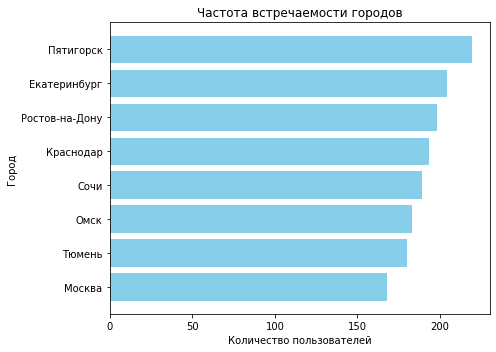

In [19]:
city_counts = users.groupby('city').agg({'user_id': 'count'}).reset_index()
city_counts.columns = ['city', 'user_count']

total_users = city_counts['user_count'].sum()

city_counts['percentage'] = round((city_counts['user_count'] / total_users) * 100)

city_counts_sorted = city_counts.sort_values(by='user_count', ascending=True).reset_index(drop=True)

print(city_counts_sorted)


plt.figure(figsize=(7, 5))
ax = plt.barh(city_counts_sorted['city'], city_counts_sorted['user_count'], color='skyblue')
plt.xlabel('Количество пользователей')
plt.ylabel('Город')
plt.title('Частота встречаемости городов')
plt.xticks(rotation=0)
plt.tight_layout() 

plt.show()

В каждом городе около 190 пользователей, наибольшее число, 219, - в Пятигорске, а наименьшее, 168, - в Москве

 Оценим соотношение пользователей с подпиской и без подписки

  subscription_type  user_count  percentage
0             ultra         699        46.0
1              free         835        54.0


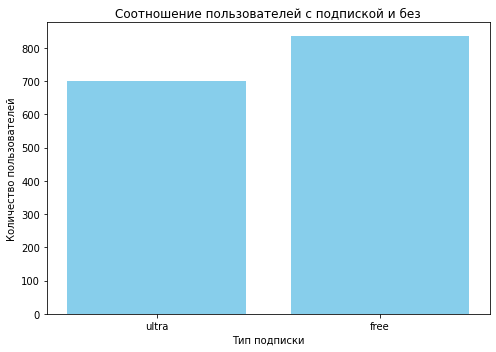

In [21]:
sub_type = users.groupby('subscription_type').agg({'user_id': 'count'}).reset_index()
sub_type.columns = ['subscription_type', 'user_count']

total_users = sub_type['user_count'].sum()

sub_type['percentage'] = round((sub_type['user_count'] / total_users) * 100)

sub_type_sorted = sub_type.sort_values(by='user_count', ascending=True).reset_index(drop=True)

print(sub_type_sorted)

plt.figure(figsize=(7, 5))
plt.bar(sub_type_sorted['subscription_type'], sub_type_sorted['user_count'], color='skyblue')
plt.xlabel('Тип подписки')
plt.ylabel('Количество пользователей')
plt.title('Соотношение пользователей с подпиской и без')
plt.xticks(rotation=0)  
plt.tight_layout() 

# Отображаем график
plt.show()

Соотношение пользователей с подпиской и без примерно одинаковое, но пользователей без подписки немного больше (54% против 46%)

Проанализируем возраст пользователей

         age_group  user_count  percentage
0  от 18 до 29 лет        1212        79.0
1  от 30 до 39 лет         242        16.0
2        до 18 лет          79         5.0
3    старше 40 лет           1         0.0


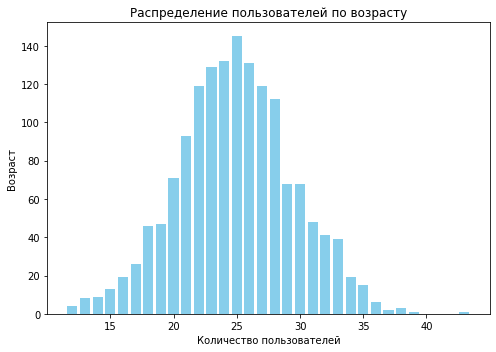

In [23]:
# для удобства разобъём значения возраста на группы
def categorize_age(age):
    if age < 18:
        return 'до 18 лет'
    elif 18 <= age < 30:
        return 'от 18 до 29 лет'
    elif 30 <= age < 40:
        return 'от 30 до 39 лет'
    else:
        return 'старше 40 лет'

users['age_group'] = users['age'].apply(categorize_age)

age_group_counts = users.groupby('age_group').agg({'user_id': 'count'}).reset_index()
age_group_counts.columns = ['age_group', 'user_count']

total_users = age_group_counts['user_count'].sum()

age_group_counts['percentage'] = round((age_group_counts['user_count'] / total_users) * 100)

age_group_counts_sorted = age_group_counts.sort_values(by='user_count', ascending=False).reset_index(drop=True)

print(age_group_counts_sorted)

age_counts = users.groupby('age').agg({'user_id': 'count'}).reset_index()
age_counts = age_counts.sort_values(by='user_id', ascending=False).reset_index(drop=True)

plt.figure(figsize=(7, 5))
plt.bar(age_counts['age'], age_counts['user_id'], color='skyblue')
plt.xlabel('Количество пользователей')
plt.ylabel('Возраст')
plt.title('Распределение пользователей по возрасту')
plt.xticks(rotation=0)  
plt.tight_layout()  

plt.show()

Наибольшее количество пользователей находится в возрасте от 18 до 29 лет (наибольшему числу пользователей 25 лет)

Теперь оценим расстояние, которое пользователь преодолел за одну поездку

In [24]:
riders.describe() # посмотрим на данные, чтобы понятнее было, на какие группы разбить

,user_id,distance,duration,month
count,18068.000000,18068.000000,18068.000000,18068.000000
mean,842.869936,3070.659992,17.805011,6.486772
std,434.734317,1116.831222,6.091051,3.437410
min,1.000000,0.860000,0.500000,1.000000
25%,487.000000,2543.227500,13.597563,4.000000
50%,889.000000,3133.610000,17.678395,6.000000
75%,1213.250000,3776.220000,21.724800,9.000000
max,1534.000000,7211.010000,40.823963,12.000000


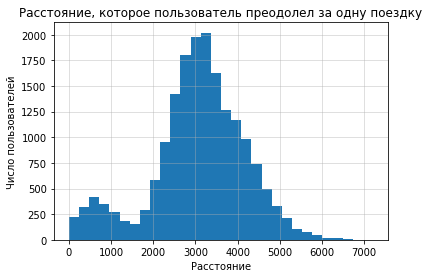

In [25]:
riders['distance'].plot.hist(bins=30);
plt.xlabel('Расстояние')
plt.ylabel('Число пользователей')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.grid(alpha=0.5)

plt.show()

Наибольшее число пользователей проезжают за одну поездку чуть больше 3х км, также есть небольшой вспелск около 600 метров

        distance  user_id  percentage
0   больше 7 км.        2         0.0
7  от 6 до 7 км.       44         0.0
6  от 5 до 6 км.      495         3.0
2  от 1 до 2 км.      980         5.0
1       до 1 км.     1372         8.0
5  от 4 до 5 км.     2937        16.0
3  от 2 до 3 км.     5540        31.0
4  от 3 до 4 км.     6698        37.0


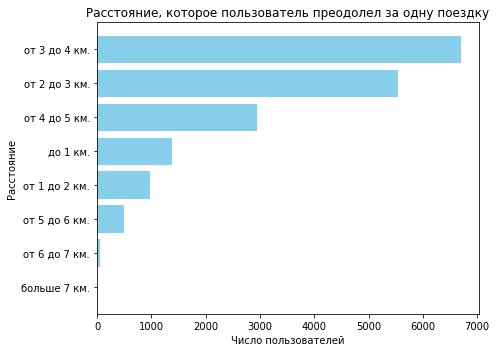

In [26]:
def categorize_distance(distance):
    if distance < 1000:
        return 'до 1 км.'
    elif 1000 <= distance < 2000:
        return 'от 1 до 2 км.'
    elif 2000 <= distance < 3000:
        return 'от 2 до 3 км.'
    elif 3000 <= distance < 4000:
        return 'от 3 до 4 км.'
    elif 4000 <= distance < 5000:
        return 'от 4 до 5 км.'
    elif 5000 <= distance < 6000:
        return 'от 5 до 6 км.'
    elif 6000 <= distance < 7000:
        return 'от 6 до 7 км.'
    else:
        return 'больше 7 км.'

df_distance = riders.copy(deep=True)
df_distance['distance'] = df_distance['distance'].apply(categorize_distance)

df_distance = df_distance.groupby('distance').agg({'user_id': 'count'})
df_distance.reset_index(inplace=True)
total_users = df_distance['user_id'].sum()
df_distance['percentage'] = round((df_distance['user_id'] / total_users) * 100)
df_distance = df_distance.sort_values(by='user_id', ascending=True)

print(df_distance)

plt.figure(figsize=(7, 5))
# Построение горизонтальной диаграммы
plt.barh(df_distance['distance'], df_distance['user_id'], color='skyblue')
plt.xlabel('Число пользователей')
plt.ylabel('Расстояние')
plt.title('Расстояние, которое пользователь преодолел за одну поездку')
plt.tight_layout()

plt.show()

Более 80% пользователей проезжают за одну поездку от 2-х до 5-ти км; наибольший процент пользователей, 37%, проезжают от 3-х до 4-х км

Рассмотрим продолжительность поездок

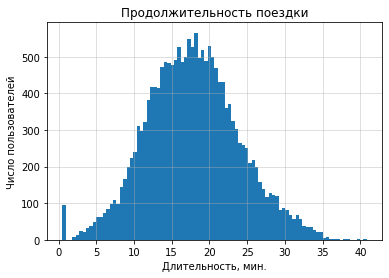

In [27]:
riders['duration'].plot.hist(bins=90);
plt.xlabel('Длительность, мин.')
plt.ylabel('Число пользователей')
plt.title('Продолжительность поездки')
plt.grid(alpha=0.5)

plt.show()

У наибольшего числа людей длительность одной поездки занимает около 18 минут, при этом есть ещё аномальное значение около 1 минуты

           duration  user_id  percentage
0    больше 35 мин.       28         0.0
1         до 5 мин.      278         2.0
2  от 30 до 35 мин.      515         3.0
3   от 5 до 10 мин.     1361         8.0
4  от 25 до 30 мин.     1651         9.0
5  от 20 до 25 мин.     4140        23.0
6  от 10 до 15 мин.     4374        24.0
7  от 15 до 20 мин.     5721        32.0


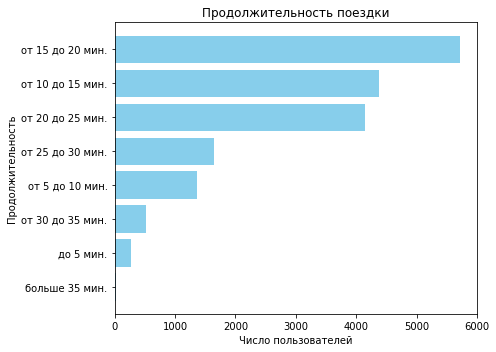

In [28]:
def categorize_duration(duration):
    if duration < 5:
        return 'до 5 мин.'
    elif 5 <= duration < 10:
        return 'от 5 до 10 мин.'
    elif 10 <= duration < 15:
        return 'от 10 до 15 мин.'
    elif 15 <= duration < 20:
        return 'от 15 до 20 мин.'
    elif 20 <= duration < 25:
        return 'от 20 до 25 мин.'
    elif 25 <= duration < 30:
        return 'от 25 до 30 мин.'
    elif 30 <= duration < 35:
        return 'от 30 до 35 мин.'
    else:
        return 'больше 35 мин.'

df = riders.copy(deep=True)
df['duration'] = df['duration'].apply(categorize_duration)

df = df.groupby('duration').agg({'user_id': 'count'}).reset_index()
total_users = df['user_id'].sum()
df['percentage'] = round((df['user_id'] / total_users) * 100)
df = df.sort_values(by='user_id', ascending=True).reset_index(drop=True)
print(df)

plt.figure(figsize=(7, 5))
plt.barh(df['duration'], df['user_id'], color='skyblue')
plt.xlabel('Число пользователей')
plt.ylabel('Продолжительность')
plt.title('Продолжительность поездки')
plt.xticks(rotation=0)  
plt.tight_layout() 

plt.show()

Продолжительность одной поездки около 80% пользователей составляет от 10 до 25 минут; у наибольшего процента пользователей, 32%, одна поездка занимает 15-20 минут

## Объединение данных

- преобразуем данные и посмотрим на различие расстояний и времени поездок для пользователей с подпиской и без
- подготовим данные для проверки гипотез

Начнём с объединения всех датафреймов в один

In [29]:
users.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
 5   age_group          1534 non-null   object
dtypes: int64(2), object(4)
memory usage: 83.9+ KB


In [30]:
riders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   user_id   18068 non-null  int64         
 1   distance  18068 non-null  float64       
 2   duration  18068 non-null  float64       
 3   date      18068 non-null  datetime64[ns]
 4   month     18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2)
memory usage: 705.9 KB


In [31]:
overall = users.merge(subscriptions, on='subscription_type', how='left')
overall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1534 entries, 0 to 1533
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1534 non-null   int64 
 1   name               1534 non-null   object
 2   age                1534 non-null   int64 
 3   city               1534 non-null   object
 4   subscription_type  1534 non-null   object
 5   age_group          1534 non-null   object
 6   minute_price       1534 non-null   int64 
 7   start_ride_price   1534 non-null   int64 
 8   subscription_fee   1534 non-null   int64 
dtypes: int64(5), object(4)
memory usage: 119.8+ KB


In [32]:
overall = riders.merge(overall, on='user_id', how='left')
overall.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18068 entries, 0 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   distance           18068 non-null  float64       
 2   duration           18068 non-null  float64       
 3   date               18068 non-null  datetime64[ns]
 4   month              18068 non-null  int64         
 5   name               18068 non-null  object        
 6   age                18068 non-null  int64         
 7   city               18068 non-null  object        
 8   subscription_type  18068 non-null  object        
 9   age_group          18068 non-null  object        
 10  minute_price       18068 non-null  int64         
 11  start_ride_price   18068 non-null  int64         
 12  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory 

In [33]:
overall.head()

,user_id,distance,duration,date,month,name,age,city,subscription_type,age_group,minute_price,start_ride_price,subscription_fee
0,1,4409.92,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,от 18 до 29 лет,6,0,199
1,1,2617.59,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,от 18 до 29 лет,6,0,199
2,1,754.16,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,от 18 до 29 лет,6,0,199
3,1,2694.78,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,от 18 до 29 лет,6,0,199
4,1,4028.69,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,от 18 до 29 лет,6,0,199


Разделим получившийся датафрейм на два по пользователям с подпиской и без подписки

In [34]:
free = overall[overall['subscription_type'] == 'free']
free.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11568 entries, 6500 to 18067
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   distance           11568 non-null  float64       
 2   duration           11568 non-null  float64       
 3   date               11568 non-null  datetime64[ns]
 4   month              11568 non-null  int64         
 5   name               11568 non-null  object        
 6   age                11568 non-null  int64         
 7   city               11568 non-null  object        
 8   subscription_type  11568 non-null  object        
 9   age_group          11568 non-null  object        
 10  minute_price       11568 non-null  int64         
 11  start_ride_price   11568 non-null  int64         
 12  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memo

In [35]:
free

,user_id,distance,duration,date,month,name,age,city,subscription_type,age_group,minute_price,start_ride_price,subscription_fee
6500,700,2515.69,14.944286,2021-01-02,1,Айдар,22,Омск,free,от 18 до 29 лет,8,50,0
6501,700,846.93,16.234663,2021-02-01,2,Айдар,22,Омск,free,от 18 до 29 лет,8,50,0
6502,700,4004.43,20.016628,2021-02-04,2,Айдар,22,Омск,free,от 18 до 29 лет,8,50,0
6503,700,1205.91,9.782872,2021-02-10,2,Айдар,22,Омск,free,от 18 до 29 лет,8,50,0
6504,700,3047.38,17.427673,2021-02-14,2,Айдар,22,Омск,free,от 18 до 29 лет,8,50,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
18063,1534,3781.10,19.822962,2021-11-04,11,Альберт,25,Краснодар,free,от 18 до 29 лет,8,50,0
18064,1534,2840.42,21.409799,2021-11-16,11,Альберт,25,Краснодар,free,от 18 до 29 лет,8,50,0
18065,1534,3826.19,18.435051,2021-11-18,11,Альберт,25,Краснодар,free,от 18 до 29 лет,8,50,0
18066,1534,2902.31,16.674362,2021-11-27,11,Альберт,25,Краснодар,free,от 18 до 29 лет,8,50,0


In [36]:
ultra = overall[overall['subscription_type'] == 'ultra']
ultra.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6500 entries, 0 to 6499
Data columns (total 13 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   distance           6500 non-null   float64       
 2   duration           6500 non-null   float64       
 3   date               6500 non-null   datetime64[ns]
 4   month              6500 non-null   int64         
 5   name               6500 non-null   object        
 6   age                6500 non-null   int64         
 7   city               6500 non-null   object        
 8   subscription_type  6500 non-null   object        
 9   age_group          6500 non-null   object        
 10  minute_price       6500 non-null   int64         
 11  start_ride_price   6500 non-null   int64         
 12  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int64(6), object(4)
memory us

In [37]:
ultra

,user_id,distance,duration,date,month,name,age,city,subscription_type,age_group,minute_price,start_ride_price,subscription_fee
0,1,4409.92,25.599769,2021-01-01,1,Кира,22,Тюмень,ultra,от 18 до 29 лет,6,0,199
1,1,2617.59,15.816871,2021-01-18,1,Кира,22,Тюмень,ultra,от 18 до 29 лет,6,0,199
2,1,754.16,6.232113,2021-04-20,4,Кира,22,Тюмень,ultra,от 18 до 29 лет,6,0,199
3,1,2694.78,18.511000,2021-08-11,8,Кира,22,Тюмень,ultra,от 18 до 29 лет,6,0,199
4,1,4028.69,26.265803,2021-08-28,8,Кира,22,Тюмень,ultra,от 18 до 29 лет,6,0,199
...,...,...,...,...,...,...,...,...,...,...,...,...,...
6495,699,3973.05,24.671163,2021-08-29,8,Оксана,22,Москва,ultra,от 18 до 29 лет,6,0,199
6496,699,3288.70,15.892886,2021-09-12,9,Оксана,22,Москва,ultra,от 18 до 29 лет,6,0,199
6497,699,3076.16,14.389525,2021-09-26,9,Оксана,22,Москва,ultra,от 18 до 29 лет,6,0,199
6498,699,4707.85,15.839579,2021-10-17,10,Оксана,22,Москва,ultra,от 18 до 29 лет,6,0,199


Теперь посмотрм, есть ли разница во времени и расстоянии одной поездки для пользователей с подпиской и без

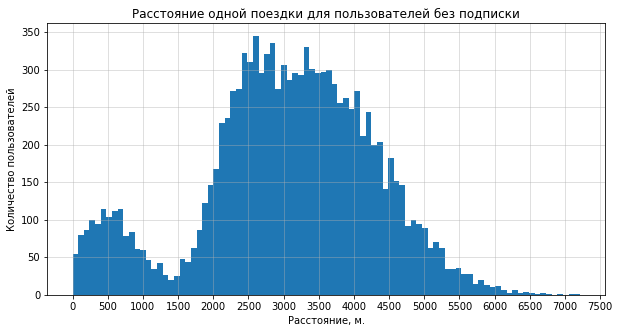

In [38]:
free['distance'].plot.hist(bins=90, figsize=(10,5));
plt.xlabel('Расстояние, м.')
plt.ylabel('Количество пользователей')
plt.title('Расстояние одной поездки для пользователей без подписки')
plt.grid(alpha=0.5)
plt.xticks(range(0, int(free['distance'].max()) + 500, 500))

plt.show()

Пользователи без подписки чаще всего проезжают 2,5 и 3,5 км, также повторяется всплеск около 500 м.

        distance  user_id  percentage
0   больше 7 км.        2         0.0
1  от 6 до 7 км.       44         0.0
2  от 5 до 6 км.      472         4.0
3  от 1 до 2 км.      728         6.0
4       до 1 км.     1113        10.0
5  от 4 до 5 км.     2085        18.0
6  от 2 до 3 км.     3523        30.0
7  от 3 до 4 км.     3601        31.0


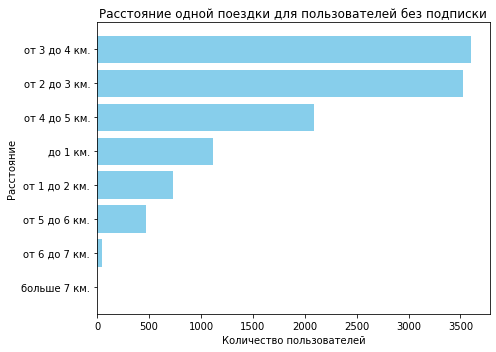

In [39]:
df = free.copy(deep=True)
df['distance'] = df['distance'].apply(categorize_distance)

df = df.groupby('distance').agg({'user_id': 'count'}).reset_index()
total_users = df['user_id'].sum()
df['percentage'] = round((df['user_id'] / total_users) * 100)
df = df.sort_values(by='user_id', ascending=True).reset_index(drop=True)
print(df)

plt.figure(figsize=(7, 5))
plt.barh(df['distance'], df['user_id'], color='skyblue')
plt.xlabel('Количество пользователей')
plt.ylabel('Расстояние')
plt.title('Расстояние одной поездки для пользователей без подписки')
plt.xticks(rotation=0)  
plt.tight_layout()  

plt.show()

Пользователи без подписки в основном проезжают за одну поездку 2-4 км.

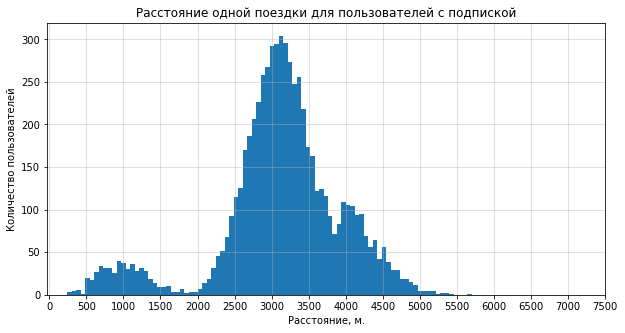

In [40]:
ultra['distance'].plot.hist(bins=90, figsize=(10,5));
plt.xlabel('Расстояние, м.')
plt.ylabel('Количество пользователей')
plt.title('Расстояние одной поездки для пользователей с подпиской')
plt.grid(alpha=0.5)
plt.xticks(range(0, int(free['distance'].max()) + 500, 500))

plt.show()

Пользователи с подпиской чаще всего проезжают на 500 м. больше пользователей без подписки. Так, наибольшее число пользователей с подпиской проезжают около 3 км, далее есть пики 4 и 1 км

        distance  user_id  percentage
0  от 5 до 6 км.       23         0.0
1  от 1 до 2 км.      252         4.0
2       до 1 км.      259         4.0
3  от 4 до 5 км.      852        13.0
4  от 2 до 3 км.     2017        31.0
5  от 3 до 4 км.     3097        48.0


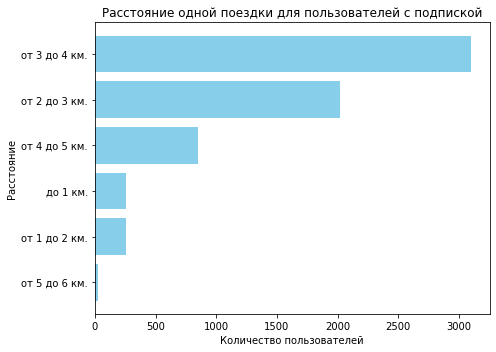

In [41]:
df = ultra.copy(deep=True)
df['distance'] = df['distance'].apply(categorize_distance)

df = df.groupby('distance').agg({'user_id': 'count'}).reset_index()
total_users = df['user_id'].sum()
df['percentage'] = round((df['user_id'] / total_users) * 100)
df = df.sort_values(by='user_id', ascending=True).reset_index(drop=True)
print(df)

plt.figure(figsize=(7, 5))
plt.barh(df['distance'], df['user_id'], color='skyblue')
plt.xlabel('Количество пользователей')
plt.ylabel('Расстояние')
plt.title('Расстояние одной поездки для пользователей с подпиской')
plt.xticks(rotation=0)  
plt.tight_layout()

plt.show()

Пользователи с подпиской также в основном проезжают за одну поездку 2-4 км., но наиболее часто 3-4 км.

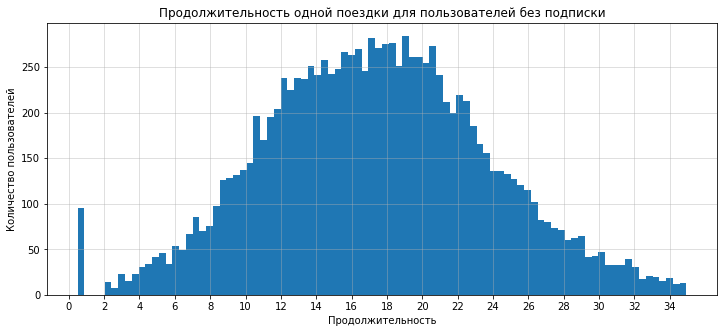

In [42]:
free['duration'].plot.hist(bins=90, figsize=(12,5));
plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей')
plt.title('Продолжительность одной поездки для пользователей без подписки')
plt.grid(alpha=0.5)
plt.xticks(range(0, int(free['duration'].max()) + 1, 2))

plt.show()

Большинство пользователей без подписки совершают свою поездку в течение 12-23 минут, также есть аномальное значение около одной минуты

           duration  user_id  percentage
0         до 5 мин.      268         2.0
1  от 30 до 35 мин.      330         3.0
2  от 25 до 30 мин.     1040         9.0
3   от 5 до 10 мин.     1091         9.0
4  от 20 до 25 мин.     2539        22.0
5  от 10 до 15 мин.     2840        25.0
6  от 15 до 20 мин.     3460        30.0


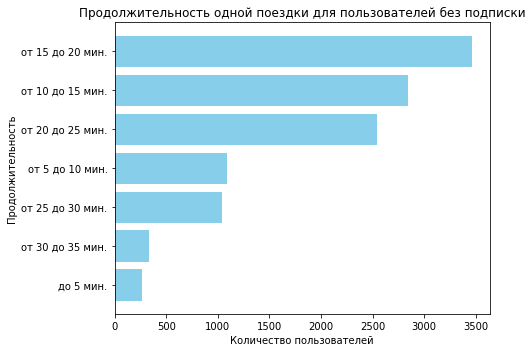

In [43]:
df = free.copy(deep=True)
df['duration'] = df['duration'].apply(categorize_duration)

df = df.groupby('duration').agg({'user_id': 'count'}).reset_index()
total_users = df['user_id'].sum()
df['percentage'] = round((df['user_id'] / total_users) * 100)
df = df.sort_values(by='user_id', ascending=True).reset_index(drop=True)
print(df)

plt.figure(figsize=(7, 5))
plt.barh(df['duration'], df['user_id'], color='skyblue')
plt.xlabel('Количество пользователей')
plt.ylabel('Продолжительность')
plt.title('Продолжительность одной поездки для пользователей без подписки')
plt.xticks(rotation=0)  
plt.tight_layout()  

plt.show()

Большинство пользователей без подписки, 77%, совершают поездку в течение 10-25 мин., наиболее популярная продолжительность 15-20 мин.

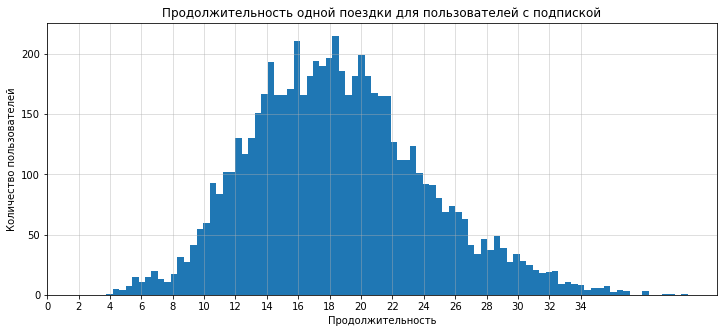

In [44]:
ultra['duration'].plot.hist(bins=90, figsize=(12,5));
plt.xlabel('Продолжительность')
plt.ylabel('Количество пользователей')
plt.title('Продолжительность одной поездки для пользователей с подпиской')
plt.grid(alpha=0.5)
plt.xticks(range(0, int(free['duration'].max()) + 1 , 2))

plt.show()

Большинство пользователей с подпиской также совершают свою поездку в течение 14-22 минут

           duration  user_id  percentage
0         до 5 мин.       10         0.0
1    больше 35 мин.       28         0.0
2  от 30 до 35 мин.      185         3.0
3   от 5 до 10 мин.      270         4.0
4  от 25 до 30 мин.      611         9.0
5  от 10 до 15 мин.     1534        24.0
6  от 20 до 25 мин.     1601        25.0
7  от 15 до 20 мин.     2261        35.0


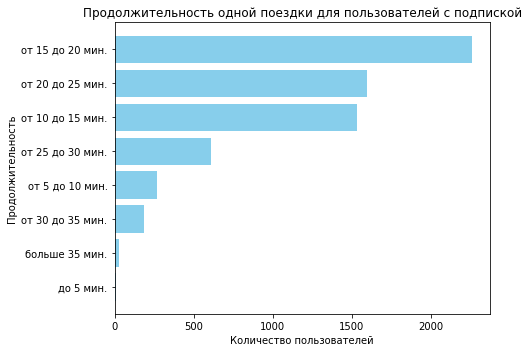

In [45]:
df = ultra.copy(deep=True)
df['duration'] = df['duration'].apply(categorize_duration)

df = df.groupby('duration').agg({'user_id': 'count'}).reset_index()
total_users = df['user_id'].sum()
df['percentage'] = round((df['user_id'] / total_users) * 100)
df = df.sort_values(by='user_id', ascending=True).reset_index(drop=True)
print(df)

plt.figure(figsize=(7, 5))
plt.barh(df['duration'], df['user_id'], color='skyblue')
plt.xlabel('Количество пользователей')
plt.ylabel('Продолжительность')
plt.title('Продолжительность одной поездки для пользователей с подпиской')
plt.xticks(rotation=0) 
plt.tight_layout() 

plt.show()

Большинство пользователей с подпиской, 84%, также совершают поездку в течение 10-25 мин., наиболее популярная продолжительность также составляет 15-20 мин.

Можно заметить, что по расстоянию и продолжительности поездок по времени больших различий не наблюдается среди пользователей с подпиской и без; разве что пользователи с подспикой чаще проезжают на 500 м больше пользователей без подписки

### Рассчитаем выручку

In [46]:
overall['duration'] = np.ceil(overall['duration']) # округляем длительность поездки до целой минуты
revenue = overall.groupby(['user_id','month']).agg({'distance':['sum', 'count'], 'duration':'sum'})
revenue.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (1534, 12)
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (distance, sum)    11331 non-null  float64
 1   (distance, count)  11331 non-null  int64  
 2   (duration, sum)    11331 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 311.0 KB


In [47]:
revenue # посмотрим на получившийся датафрейм

distance       duration
                    sum count      sum
user_id month                         
1       1       7027.51     2     42.0
        4        754.16     1      7.0
        8       6723.47     2     46.0
        10      5809.91     2     32.0
        11      7003.50     3     56.0
...                 ...   ...      ...
1534    6       3409.47     2     26.0
        8       7622.45     2     48.0
        9       4928.17     1     23.0
        11     13350.02     4     78.0
        12      2371.71     1     16.0

[11331 rows x 3 columns]

In [48]:
revenue.info() # проверим наличие пропусков

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11331 entries, (1, 1) to (1534, 12)
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   (distance, sum)    11331 non-null  float64
 1   (distance, count)  11331 non-null  int64  
 2   (duration, sum)    11331 non-null  float64
dtypes: float64(2), int64(1)
memory usage: 311.0 KB


In [49]:
revenue.columns = ['distance', 'count_of_rides', 'duration']
#revenue['duration'] = np.ceil(revenue['duration']) 
revenue = revenue.reset_index()
revenue.head()

,user_id,month,distance,count_of_rides,duration
0,1,1,7027.51,2,42.0
1,1,4,754.16,1,7.0
2,1,8,6723.47,2,46.0
3,1,10,5809.91,2,32.0
4,1,11,7003.50,3,56.0


In [50]:
# непосредственно произведём рассчёт выручки
def categorize_earnings(row):
    if row['user_id'] in ultra['user_id'].values:
        return 6 * row['duration'] + 199
    else:
        return 50 * row['count_of_rides'] + 8 * row['duration']


revenue['earnings'] = revenue.apply(categorize_earnings, axis=1)
revenue

,user_id,month,distance,count_of_rides,duration,earnings
0,1,1,7027.51,2,42.0,451.0
1,1,4,754.16,1,7.0,241.0
2,1,8,6723.47,2,46.0,475.0
3,1,10,5809.91,2,32.0,391.0
4,1,11,7003.50,3,56.0,535.0
...,...,...,...,...,...,...
11326,1534,6,3409.47,2,26.0,308.0
11327,1534,8,7622.45,2,48.0,484.0
11328,1534,9,4928.17,1,23.0,234.0
11329,1534,11,13350.02,4,78.0,824.0


In [51]:
# непосредственно произведём рассчёт выручки
def categorize_earnings(row):
    if row['user_id'] in ultra:
        return 6 * row['duration'] + 199
    elif row['user_id'] in free:
        return 50 * row['count_of_rides'] + 8 * row['duration']
    else: 
        return 0


revenue['earnin'] = revenue.apply(categorize_earnings, axis=1)
revenue

,user_id,month,distance,count_of_rides,duration,earnings,earnin
0,1,1,7027.51,2,42.0,451.0,0
1,1,4,754.16,1,7.0,241.0,0
2,1,8,6723.47,2,46.0,475.0,0
3,1,10,5809.91,2,32.0,391.0,0
4,1,11,7003.50,3,56.0,535.0,0
...,...,...,...,...,...,...,...
11326,1534,6,3409.47,2,26.0,308.0,0
11327,1534,8,7622.45,2,48.0,484.0,0
11328,1534,9,4928.17,1,23.0,234.0,0
11329,1534,11,13350.02,4,78.0,824.0,0


In [52]:
# непосредственно произведём рассчёт выручки
def categorize_earnings(row):
    if all(row['user_id'] not in s for s in (free, ultra)):
        return 0


revenue['ea'] = revenue.apply(categorize_earnings, axis=1)
revenue

,user_id,month,distance,count_of_rides,duration,earnings,earnin,ea
0,1,1,7027.51,2,42.0,451.0,0,0
1,1,4,754.16,1,7.0,241.0,0,0
2,1,8,6723.47,2,46.0,475.0,0,0
3,1,10,5809.91,2,32.0,391.0,0,0
4,1,11,7003.50,3,56.0,535.0,0,0
...,...,...,...,...,...,...,...,...
11326,1534,6,3409.47,2,26.0,308.0,0,0
11327,1534,8,7622.45,2,48.0,484.0,0,0
11328,1534,9,4928.17,1,23.0,234.0,0,0
11329,1534,11,13350.02,4,78.0,824.0,0,0


## Проверим некоторые гипотезы

1) Нулевая гипотеза: пользователи с подпиской и без тратят одинаковое время на поездки
    
   Альтернативная гипотеза: пользователи с подпиской тратят больше времени на поездки

In [55]:
alpha = 0.05

print(f"Среднее для пользователей с подпиской: {ultra['duration'].mean()},\nСреднее для пользователей без подписки: {free['duration'].mean()}\n")

results = st.ttest_ind(
    ultra['duration'], 
    free['duration'],
      alternative='greater')

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу:  пользователи с подпиской тратят больше времени на поездки')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

Среднее для пользователей с подпиской: 18.54198516280583,
Среднее для пользователей без подписки: 17.39090929866399

p-значение: 1.2804098316645618e-34
Отвергаем нулевую гипотезу:  пользователи с подпиской тратят больше времени на поездки


2) Нулевая гипотеза: среднее расстояние, которое проезжают пользователи с подпиской за одну поездку равно 3130 метров (оптимальное с точки зрения износа самоката)
    
   Альтернативная гипотеза: пользователи с подпиской в среднем проезжают больше 3130 метров за одну поездку

In [56]:
avareage_value = 3130

alpha = 0.05 

print('Среднее', ultra['distance'].mean())

results = st.ttest_1samp(
    ultra['distance'], 
    avareage_value,
      alternative='greater')

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: пользователи с подпиской в среднем проезжают больше 3130 метров за одну поездку')
else:
    print('Не отвергаем нулевую гипотезу')

Среднее 3115.445430769231
p-значение: 0.9195362605842414
Не отвергаем нулевую гипотезу


3) Нулевая гипотеза: помесячная выручка от пользователей с подпиской по месяцам *равна* выручке от пользователей без подписки
    
   Альтернативная гипотеза: помесячная выручка от пользователей с подпиской по месяцам *выше*, чем выручка от пользователей без подписки

In [57]:
# разделим датафрейм с выручкой на два датафрейма - для пользователей с подпиской и без
revenue_ultra = revenue[revenue['user_id'].isin(ultra['user_id'])]
revenue_ultra

,user_id,month,distance,count_of_rides,duration,earnings,earnin,ea
0,1,1,7027.51,2,42.0,451.0,0,0
1,1,4,754.16,1,7.0,241.0,0,0
2,1,8,6723.47,2,46.0,475.0,0,0
3,1,10,5809.91,2,32.0,391.0,0,0
4,1,11,7003.50,3,56.0,535.0,0,0
...,...,...,...,...,...,...,...,...
4528,699,6,4072.80,1,17.0,301.0,0,0
4529,699,8,7018.33,2,45.0,469.0,0,0
4530,699,9,6364.86,2,31.0,385.0,0,0
4531,699,10,4707.85,1,16.0,295.0,0,0


In [58]:
revenue_free = revenue[revenue['user_id'].isin(free['user_id'])]
revenue_free

,user_id,month,distance,count_of_rides,duration,earnings,earnin,ea
4533,700,1,2515.69,1,15.0,170.0,0,0
4534,700,2,13446.65,5,89.0,962.0,0,0
4535,700,3,3798.33,1,19.0,202.0,0,0
4536,700,4,2984.55,1,16.0,178.0,0,0
4537,700,6,5927.65,2,29.0,332.0,0,0
...,...,...,...,...,...,...,...,...
11326,1534,6,3409.47,2,26.0,308.0,0,0
11327,1534,8,7622.45,2,48.0,484.0,0,0
11328,1534,9,4928.17,1,23.0,234.0,0,0
11329,1534,11,13350.02,4,78.0,824.0,0,0


In [59]:
alpha = 0.05

results = st.ttest_ind(
    revenue_ultra['earnings'], 
    revenue_free['earnings'],
      alternative='greater')

print('p-значение:', results.pvalue) 

if (results.pvalue < alpha):
    print('Отвергаем нулевую гипотезу: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки')
else:
    print('Не получилось отвергнуть нулевую гипотезу')

p-значение: 1.8850394384715216e-31
Отвергаем нулевую гипотезу: помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки


Интересно! Посмотрим на цифры

In [60]:
print (f"Средний помесячный доход от пользователя с подпиской: {round(revenue_ultra['earnings'].sum()/revenue_ultra['earnings'].count())},\nСредний помесячный доход от пользователя без подписки: {round(revenue_free['earnings'].sum()/revenue_free['earnings'].count())}")

Средний помесячный доход от пользователя с подпиской: 363,
Средний помесячный доход от пользователя без подписки: 329


Также ради интереса посмотрим на динамику доходов

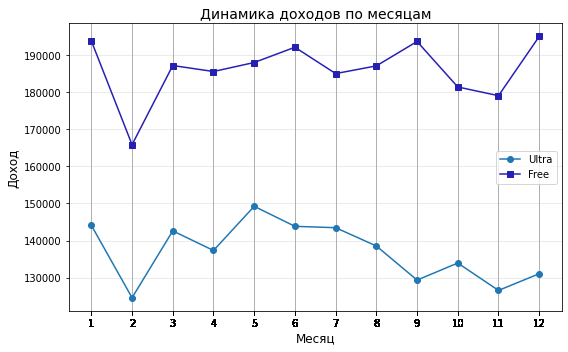

In [61]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

# Рисуем линии для Ultra и Free
plt.plot(revenue_ultra.groupby('month').agg({'earnings':'sum'}).reset_index()['month'], 
         revenue_ultra.groupby('month').agg({'earnings':'sum'}).reset_index()['earnings'], 
         label='Ultra', 
         marker='o',
         color='#1f77b4')

plt.plot(revenue_free.groupby('month').agg({'earnings':'sum'}).reset_index()['month'], 
         revenue_free.groupby('month').agg({'earnings':'sum'}).reset_index()['earnings'], 
         label='Free', 
         marker='s',
         color='#261fb4')


plt.title('Динамика доходов по месяцам', fontsize=14)
plt.xlabel('Месяц', fontsize=12)
plt.ylabel('Доход', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend()
plt.xticks(revenue_ultra['month'])  

plt.tight_layout()

plt.show()

В среднем, один пользователь с подпиской приносит больший доход в месяц, чем пользователь без подписки, но из-за того, что пользователей без подписки больше, на протяжении всего года они приносили больший доход 

In [62]:
print (f"Сумма доходов от пользователей с подпиской:  {revenue_ultra['earnings'].sum()},\nСумма доходов от пользователей без подписки: {revenue_free['earnings'].sum()}")

Сумма доходов от пользователей с подпиской:  1644537.0,
Сумма доходов от пользователей без подписки: 2234104.0


4) Теоритическая ситуация: : техническая команда сервиса обновила сервера, с которыми взаимодействует мобильное приложение. Она надеется, что из-за этого количество обращений в техподдержку значимо снизилось. Некоторый файл содержит для каждого пользователя данные о количестве обращений до обновления и после него

В данном случае рассматривается одна и та же генеральная совокупность и 
некоторая переменная измерена два раза для одних и тех ж  объекто 
наблюдения — до и посто изменен, значит необходимо использовать двухвыборочный t-тест для зависимых выборок. 

**Нулевая гипотеза:** количества обращений в техподдержку до и после обновления *равны* 
    
**Альтернативная гипотеза:** количество обращений в техподдержку после обновления *ниже*, чем до обновления

Нам понадобится **метод** st.ttest_rel(
    данные после обновления, 
    данные до обновления,
      alternative='less')


### Выводы:


Мы проанализировали данные о пользователях, их поездках и подписках и проверили гипотезы, которые могут помочь масштабированию бизнеса. Для этого выполнили следующие шаги:

1. Загрузили данные и подготовили их к анализу
2. Выполнили исследовательский анализ данных
3. Проверили гипотезы

Выводы по разделу первичного анализа и предобработки данных:

- в данных не было пропусков
- в данных о пользователях было несколько дубликатов, можно проверить систему сбора данных

Такие данные позволяют провести качественный анализ


Основные результаты:

Описание пользователей:
- в каждом городе, где представлено приложение, около 190 пользователей; наибольшее число, 219, - в Пятигорске, а наименьшее, 168, - в Москве;
- соотношение пользователей с подпиской и без примерно одинаковое, но пользователей без подписки немного больше (54% против 46%);
- наибольшее количество пользователей находится в возрасте от 18 до 29 лет (наибольшему числу пользователей 25 лет);
- более 80% пользователей проезжают за одну поездку от 2-х до 5-ти км; наибольший процент пользователей, 37%, проезжают от 3-х до 4-х км;
- продолжительность одной поездки около 80% пользователей составляет от 10 до 25 минут; у наибольшего процента пользователей, 32%, одна поездка занимает 15-20 минут;


Сравнение пользователей с подпиской и без:

- пользователи без подписки чаще всего проезжают 2,5 и 3,5 км, также наблюдается экстремум около 500 м;
- пользователи с подпиской чаще всего проезжают на 500 м больше пользователей без подписки. Так, наибольшее число пользователей с подпиской проезжают около 3 км, также на графике есть пики 4 и 1 км;

- большинство пользователей без подписки совершают свою поездку в течение 12-23 минут, также есть аномальное значение около одной минуты;
- большинство пользователей с подпиской также совершают свою поездку в течение 14-22 минут;


Портрет типичного пользователя приложения: 
- житель Пятигорска 25-ти лет без подписки, проезжающий за одну поездку 3-4 км в течение 15-20 минут

Результаты проверки гипотез:
- по расстоянию и продолжительности поездок по времени больших различий не наблюдается среди пользователей с подпиской и без подписки, хотя пользователи с подпиской тратят немного больше времени на поездки (в среднем, 18 мин. против 17 мин.);

- среднее расстояние, которое проезжают пользователи с подпиской за одну поездку, не превышает 3130 метров, поэтому с износом самокатов не должно быть проблем;

- в среднем, один пользователь с подпиской приносит больший доход в месяц, чем пользователь без подписки, но из-за того, что пользователей без подписки больше, на протяжении всего года они приносили больший доход;

Рекомендации:

**Так как больший доход всё-таки приносят пользователи с подпиской, то необходимо не только привлекать новых клиентов и распространять приложение в других городах, но и инвестировать в рекламу подписки, чтобы постоянные клиенты без подписки оформляли её.**

Также, так как в данных имелось несколько дубликатов, можно проверить систему сбора данных. 

И необходимо выяснить, почему немалая часть пользователей совершает аномально короткие поездки (около 1 км или длительностью несколько минут). Это проблема в данных (ошибка системы сбора данных), проблема с самокатом (мало заряда/ ложный старт) или что-то ещё.